In [89]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [90]:
# get data files
#!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

#!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [91]:
# import csv data into dataframes
dfb = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

dfr = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [11]:
dfb.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [12]:
dfb.describe()

,isbn,title,author
count,271379,271379,271378
unique,271379,242154,102042
top,0060254653,Selected Poems,Agatha Christie
freq,1,27,632


In [14]:
dfb.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [15]:
# Check the data types.
dfb.dtypes

isbn      object
title     object
author    object
dtype: object

In [93]:
# Find a book by title
dfb[dfb.title == 'The Queen of the Damned (Vampire Chronicles (Paperback))']

,isbn,title,author
2527,0345351525,The Queen of the Damned (Vampire Chronicles (P...,Anne Rice
72840,0833563505,The Queen of the Damned (Vampire Chronicles (P...,Anne Rice


## Analyze the data

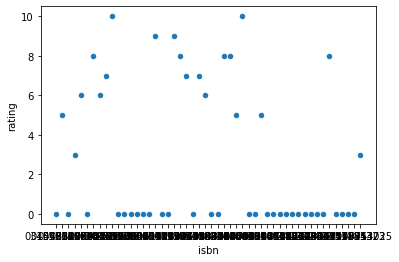

In [16]:
dfr[:50].plot(y="rating", x="isbn", kind='scatter')

### Unique values



In [17]:
dfr1 = dfr.copy() # make a deep copy
dfr1.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [18]:
dfr1.rating.unique()

array([ 0.,  5.,  3.,  6.,  8.,  7., 10.,  9.,  4.,  1.,  2.],
      dtype=float32)

In [19]:
rating_vocab = dfr1.rating.sort_values().unique().tolist()
rating_vocab

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

### Number of users

In [20]:
user_vocab = dfr1.user.sort_values().unique().tolist()
print("Number of users -", len(user_vocab))

Number of users - 105283


In [21]:
dfr1.shape

(1149780, 3)

### Number of Books

In [22]:
dfb1 = dfb.copy() # make a deep copy
dfb1.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [23]:
book_list = dfb1.title.sort_values().unique().tolist()
print("Number of Books -", len(book_list))

Number of Books - 242154


In [24]:
authr_list = dfb1.author.sort_values().unique().tolist()
print("Number of Authors -", len(authr_list))

Number of Authors - 102043


In [25]:
dfb1.shape

(271379, 3)

## Clean Books Data

Drop duplicate rows. Some titles have two isbn.

In [26]:
print("Size before - ", dfb.size)
dfb1 = dfb1.drop_duplicates(subset=['title', 'author'], keep='first')
print("Size After - ", dfb.size)


Size before -  814137
Size After -  814137


### Add numeric isbn

In [29]:
# Change the column type to be Categorical.
dfb1.isbn = pd.Categorical(dfb1.isbn)

# Now add a new Numeric Column for the isbn Categorical column
dfb1['isbn_numeric'] = dfb1.isbn.cat.codes
dfb1.head()


,isbn,title,author,isbn_numeric
0,0195153448,Classical Mythology,Mark P. O. Morford,22719
1,0002005018,Clara Callan,Richard Bruce Wright,67
2,0060973129,Decision in Normandy,Carlo D'Este,7343
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,55888
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,66093


In [220]:
df.shape

(127039, 6)

## Clean Ratings Data

To ensure statistical significance, we remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

### Filter using groupby and transform

In [4]:
dfr2 = dfr.copy() # make a deep copy to test
dfr2.shape

(1149780, 3)

In [31]:
dfr2.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [66]:
dfr2[:10].groupby(by="user").rating

In [67]:
dfr2[:10].groupby(by="user").rating.head()

0     0.0
1     5.0
2     0.0
3     3.0
4     6.0
5     0.0
6     8.0
7     6.0
8     7.0
9    10.0
Name: rating, dtype: float32

In [72]:
dfr2[:10].groupby(by="user").rating.transform('count')

0    1
1    1
2    1
3    2
4    2
5    1
6    1
7    1
8    1
9    1
Name: rating, dtype: int64

In [73]:
# users that have given more than 1 rating
dfr2[:10].groupby(by="user").rating.transform('count') > 1

0    False
1    False
2    False
3     True
4     True
5    False
6    False
7    False
8    False
9    False
Name: rating, dtype: bool

In [75]:
# Give me all users that have given more than 1 rating
dfr2[:10][dfr2[:10].groupby(by="user").rating.transform('count') > 1]

,user,isbn,rating
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [ ]:
dfr2[:10].groupby(by="user").count()

In [47]:
dfr2[:10].groupby(by="user").size()

user
276725    1
276726    1
276727    1
276729    2
276733    1
276736    1
276737    1
276744    1
276745    1
dtype: int64

In [50]:
dfr2[:10].groupby(by="user").rank()

,rating
0,1.0
1,1.0
2,1.0
3,1.0
4,2.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [53]:
dfr2[:10].groupby(by="user").filter(lambda x : print(x))

     user        isbn  rating
0  276725  034545104X     0.0
     user        isbn  rating
1  276726  0155061224     5.0
     user        isbn  rating
2  276727  0446520802     0.0
     user        isbn  rating
3  276729  052165615X     3.0
4  276729  0521795028     6.0
     user        isbn  rating
5  276733  2080674722     0.0
     user        isbn  rating
6  276736  3257224281     8.0
     user        isbn  rating
7  276737  0600570967     6.0
     user        isbn  rating
8  276744  038550120X     7.0
     user       isbn  rating
9  276745  342310538    10.0


,user,isbn,rating


In [59]:
dfr2[:10].groupby(by="user").filter(lambda x : print(len(x)))

1
1
1
2
1
1
1
1
1


,user,isbn,rating


In [76]:
# Give me all users that have given more than 1 rating
dfr2[:10].groupby(by="user").filter(lambda x : len(x)>1)

,user,isbn,rating
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [7]:
# Group by user. This returns as DataFrameGroupBy Object
dfr2.groupby(by="user")

In [11]:
# Group by user. Then replace the columns values by the count of each group. transform() returns
# a DataFrame having the same indexes as the original object filled with the transformed values.
dfr2.groupby(by="user").transform('count')

,isbn,rating
0,1,1
1,1,1
2,1,1
3,2,2
4,2,2
...,...,...
1149775,17,17
1149776,1,1
1149777,1,1
1149778,1,1


In [6]:
# Group by user, get the rating column. This reaturns the SeriesGroupBy (not the DataFrameGroupBy) object.
dfr2.groupby(by="user").rating

In [5]:
# Group by user, get the rating column and transform the values to group count. Indexes are not lost here as well.
dfr2.groupby(by="user").rating.transform('count')

0           1
1           1
2           1
3           2
4           2
           ..
1149775    17
1149776     1
1149777     1
1149778     1
1149779     1
Name: rating, Length: 1149780, dtype: int64

In [12]:
# Group by user, get the rating column and transform the values to group count. Find ones that are greater than 10.
dfr2.groupby(by="user").rating.transform('count') > 10

0          False
1          False
2          False
3          False
4          False
           ...  
1149775     True
1149776    False
1149777    False
1149778    False
1149779    False
Name: rating, Length: 1149780, dtype: bool

In [13]:
# Group by user, get the rating column and transform the values to group count. Find ones that are 
# greater than 10. Apply this mask on the orginal dataframe. It will work since indexes are same !!
dfr2[dfr2.groupby(by="user").rating.transform('count') > 10]

,user,isbn,rating
31,276762,034544003X,0.0
32,276762,0380000059,0.0
33,276762,0380711524,5.0
34,276762,0451167317,0.0
35,276762,0451454952,0.0
...,...,...,...
1149771,276704,0743211383,7.0
1149772,276704,080410526X,0.0
1149773,276704,0806917695,5.0
1149774,276704,0876044011,0.0


In [77]:
# Give me all users that have given more than 200 rating using transform function ---Fast---
dfr2[dfr2.groupby(by="user").rating.transform('count') > 200]

,user,isbn,rating
1456,277427,002542730X,10.0
1457,277427,0026217457,0.0
1458,277427,003008685X,8.0
1459,277427,0030615321,0.0
1460,277427,0060002050,0.0
...,...,...,...
1147612,275970,3829021860,0.0
1147613,275970,4770019572,0.0
1147614,275970,896086097,0.0
1147615,275970,9626340762,8.0


In [78]:
# Give me all users that have given more than 200 rating using filter function. ---Slow---
dfr2.groupby(by="user").filter(lambda x : len(x)>200)

,user,isbn,rating
1456,277427,002542730X,10.0
1457,277427,0026217457,0.0
1458,277427,003008685X,8.0
1459,277427,0030615321,0.0
1460,277427,0060002050,0.0
...,...,...,...
1147612,275970,3829021860,0.0
1147613,275970,4770019572,0.0
1147614,275970,896086097,0.0
1147615,275970,9626340762,8.0


In [15]:
# Users that have given more than 200 ratings
maskA = dfr2.groupby(by="user").rating.transform('count') > 200

In [16]:
maskA

0          False
1          False
2          False
3          False
4          False
           ...  
1149775    False
1149776    False
1149777    False
1149778    False
1149779    False
Name: rating, Length: 1149780, dtype: bool

In [17]:
# Books that have more than 100 ratings
maskB = dfr2.groupby(by="isbn").rating.transform('count') > 100

In [18]:
maskB

0          False
1          False
2           True
3          False
4          False
           ...  
1149775    False
1149776    False
1149777    False
1149778    False
1149779    False
Name: rating, Length: 1149780, dtype: bool

In [19]:
# Users who have given more than 200 reviews and books that have more than 100 reviews received.
dfr2[maskA & maskB]

,user,isbn,rating
1456,277427,002542730X,10.0
1469,277427,0060930535,0.0
1471,277427,0060934417,0.0
1474,277427,0061009059,9.0
1484,277427,0140067477,0.0
...,...,...,...
1147304,275970,0804111359,0.0
1147436,275970,140003065X,0.0
1147439,275970,1400031346,0.0
1147440,275970,1400031354,0.0


### Clean using value counts

In [79]:
vc = dfr['user'].value_counts()
vc

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
158698        1
17920         1
277135        1
275086        1
187812        1
Name: user, Length: 105283, dtype: int64

In [84]:
# Users that occur more than 200 times.
vc200 = vc[vc>200]
vc200

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
28634       201
188951      201
9856        201
268622      201
274808      201
Name: user, Length: 899, dtype: int64

In [85]:
vc200.index

Int64Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352,
            110973, 235105,
            ...
            260183, 155916,  44296,  73681,  59727,  28634, 188951,   9856,
            268622, 274808],
           dtype='int64', length=899)

In [87]:
vc200.values

array([13602,  7550,  6109,  5891,  5850,  4785,  4533,  3367,  3100,
        3067,  2991,  2948,  2674,  2529,  2512,  2507,  2504,  2459,
        2448,  2421,  2352,  2347,  2340,  2317,  2317,  2236,  2154,
        2100,  2017,  1973,  1924,  1915,  1879,  1819,  1810,  1804,
        1747,  1737,  1718,  1708,  1685,  1670,  1623,  1607,  1606,
        1571,  1550,  1549,  1535,  1534,  1531,  1503,  1493,  1488,
        1476,  1408,  1385,  1382,  1380,  1376,  1365,  1354,  1351,
        1349,  1339,  1332,  1331,  1329,  1325,  1314,  1313,  1310,
        1292,  1281,  1276,  1258,  1246,  1246,  1221,  1221,  1206,
        1206,  1204,  1201,  1177,  1172,  1170,  1163,  1162,  1158,
        1158,  1153,  1153,  1129,  1124,  1116,  1115,  1110,  1107,
        1104,  1104,  1104,  1100,  1099,  1068,  1060,  1060,  1059,
        1045,  1038,  1036,  1017,  1011,  1007,  1005,  1005,  1001,
         995,   993,   980,   978,   962,   960,   959,   956,   952,
         941,   933,

In [81]:
# This is wrong way. No errors but it is not doing what you wanted !!
dfr[dfr.user.isin(vc200)]

"""
isin() caveat -
The result will only be true at a location if all the labels match. If values is a Series, 
that’s the index. If values is a dict, the keys must be the column names, which must match. 
If values is a DataFrame, then both the index and column labels must match.
"""

,user,isbn,rating
9889,202,0140252800,6.0
9890,204,0451452755,0.0
9891,204,0812575482,0.0
9892,207,044651747X,0.0
9893,212,0060801263,8.0
...,...,...,...
24639,5850,0380716542,10.0
24640,5850,0380792486,0.0
24641,5850,0679735909,0.0
25276,6109,0689832923,10.0


In [83]:
# Right way - Match on index by passing a Series of index.
dfr[dfr.user.isin(vc200.index)]

,user,isbn,rating
1456,277427,002542730X,10.0
1457,277427,0026217457,0.0
1458,277427,003008685X,8.0
1459,277427,0030615321,0.0
1460,277427,0060002050,0.0
...,...,...,...
1147612,275970,3829021860,0.0
1147613,275970,4770019572,0.0
1147614,275970,896086097,0.0
1147615,275970,9626340762,8.0


In [20]:
# Results look right. Lest save the Dataframe this time

dfr3 = dfr2[maskA & maskB]

In [21]:
dfr3.head()

,user,isbn,rating
1456,277427,002542730X,10.0
1469,277427,0060930535,0.0
1471,277427,0060934417,0.0
1474,277427,0061009059,9.0
1484,277427,0140067477,0.0


In [25]:
# Reshape data (produce a “pivot” table) based on column values. Uses unique values from 
# specified index / columns to form axes of the resulting DataFrame.
# See https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

dfr3.pivot(index='isbn', columns='user', values='rating')

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,
002542730X,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
0060008032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0060096195,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
006016848X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
0060173289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573227331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1573229326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1573229571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Create a spreadsheet-style pivot table as a DataFrame. More flexible than pivot function.
pd.pivot_table(dfr3, values='rating', index=['isbn'], columns=['user'], fill_value=0)

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,
002542730X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,0
0060008032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0060096195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
006016848X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0060173289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573227331,0,0,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1573229326,0,0,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1573229571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
pt = pd.pivot_table(dfr3, values='rating', index=['isbn'], columns=['user'], fill_value=0)
A = csr_matrix(pt)
A.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [236]:
# Group by users and then add up the ratings for each Group. If the total is less than 200, drop that user.

# transform will return a Series having the same indexes as the original object filled with the 
# transformed values. transform will maintain index. So you can work on two datasets and then merge them again.

users_grouped = df2.groupby(by="user")['rating'].transform(sum)
print(users_grouped)
df2[users_grouped > 199]

0           0.0
1           5.0
2           0.0
3           9.0
4           9.0
           ... 
1149775    32.0
1149776     0.0
1149777    10.0
1149778    10.0
1149779     8.0
Name: rating, Length: 1149780, dtype: float32


,user,isbn,rating
173,276847,0446364193,0.0
174,276847,3257200552,5.0
175,276847,3379015180,0.0
176,276847,3404145909,8.0
177,276847,3404148576,8.0
...,...,...,...
1149744,276688,0836236688,10.0
1149745,276688,0892966548,10.0
1149746,276688,1551669315,6.0
1149747,276688,1575660792,7.0


In [167]:
# Group by books and then add up the ratings for each Group. If the total is less than 100, drop that user.

books_grouped = df2.groupby(by="isbn")['rating'].transform(sum)
print(books_grouped)
df2[books_grouped > 99]

0          176.0
1            5.0
2          471.0
3            3.0
4            6.0
           ...  
1149775     21.0
1149776    117.0
1149777    152.0
1149778     18.0
1149779      8.0
Name: rating, Length: 1149780, dtype: float32


,user,isbn,rating
0,276725,034545104X,0.0
2,276727,0446520802,0.0
8,276744,038550120X,7.0
10,276746,0425115801,0.0
11,276746,0449006522,0.0
...,...,...,...
1149768,276704,0446605409,0.0
1149771,276704,0743211383,7.0
1149772,276704,080410526X,0.0
1149776,276706,0679447156,0.0


In [168]:
df2[(books_grouped > 99) & (users_grouped > 199)]

,user,isbn,rating
173,276847,0446364193,0.0
175,276847,3379015180,0.0
179,276847,3423071516,10.0
182,276847,3426029553,8.0
210,276847,3551551677,10.0
...,...,...,...
1149726,276688,0679751521,0.0
1149731,276688,068484267X,0.0
1149738,276688,0688156134,8.0
1149743,276688,0836218655,10.0


In [169]:
# Tests worked okay. Run the cleanup one more time and save it this time !!
dfr = df2[(books_grouped > 99) & (users_grouped > 199)]
dfr.head()

,user,isbn,rating
173,276847,0446364193,0.0
175,276847,3379015180,0.0
179,276847,3423071516,10.0
182,276847,3426029553,8.0
210,276847,3551551677,10.0


In [170]:
dfr

,user,isbn,rating
173,276847,0446364193,0.0
175,276847,3379015180,0.0
179,276847,3423071516,10.0
182,276847,3426029553,8.0
210,276847,3551551677,10.0
...,...,...,...
1149726,276688,0679751521,0.0
1149731,276688,068484267X,0.0
1149738,276688,0688156134,8.0
1149743,276688,0836218655,10.0


In [171]:
dfr.shape

(151560, 3)

## Merge DataFrames

In [68]:
df_b50 = dfb[:500].copy()
df_b50.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [69]:
df_r50 = dfr[:500].copy()
df_r50.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [70]:
pd.merge(df_b50, df_r50, on='isbn')

,isbn,title,author,user,rating
0,0971880107,Wild Animus,Rich Shapero,276925,0.0
1,0804106304,The Joy Luck Club,Amy Tan,276925,0.0
2,1853262404,Heart of Darkness (Wordsworth Collection),Joseph Conrad,276925,0.0
3,0451166892,The Pillars of the Earth,Ken Follett,276755,5.0
4,0330332775,Bridget Jones's Diary,Helen Fielding,276796,5.0
5,0449006522,Manhattan Hunt Club,JOHN SAUL,276746,0.0
6,0486282112,Frankenstein (Dover Thrift Editions),Mary Wollstonecraft Shelley,276925,0.0
7,0451527747,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,276925,0.0
8,0316666343,The Lovely Bones: A Novel,Alice Sebold,276925,0.0
9,8427007450,Desaparecido: LA Autentica Historia De LA Ejec...,Thomas Hauser,276925,0.0


In [222]:
# Tests look good on smaller dataset. Now lets do it again and save it for next step.
print(df_books.shape, df_ratings, dfr.shape, dfb.shape)
dfab = pd.merge(dfb, dfr, on='isbn')
dfab

(271379, 3)            user         isbn  rating
0        276725   034545104X     0.0
1        276726   0155061224     5.0
2        276727   0446520802     0.0
3        276729   052165615X     3.0
4        276729   0521795028     6.0
...         ...          ...     ...
1149775  276704   1563526298     9.0
1149776  276706   0679447156     0.0
1149777  276709   0515107662    10.0
1149778  276721   0590442449    10.0
1149779  276723  05162443314     8.0

[1149780 rows x 3 columns] (151560, 3) (251204, 4)


,isbn,title,author,isbn_numeric,user,rating
0,0399135782,The Kitchen God's Wife,Amy Tan,71467,11676,9.0
1,0399135782,The Kitchen God's Wife,Amy Tan,71467,29526,9.0
2,0399135782,The Kitchen God's Wife,Amy Tan,71467,36836,0.0
3,0399135782,The Kitchen God's Wife,Amy Tan,71467,46398,9.0
4,0399135782,The Kitchen God's Wife,Amy Tan,71467,113270,0.0
...,...,...,...,...,...,...
127034,0310205719,The Purpose-Driven Life: What on Earth Am I He...,Rick Warren,27672,249862,0.0
127035,0310205719,The Purpose-Driven Life: What on Earth Am I He...,Rick Warren,27672,253556,0.0
127036,0310205719,The Purpose-Driven Life: What on Earth Am I He...,Rick Warren,27672,256407,9.0
127037,0310205719,The Purpose-Driven Life: What on Earth Am I He...,Rick Warren,27672,257700,9.0


In [173]:
dfab.shape

(127039, 5)

## Create Training data

In [180]:
# Group by isbn_numeric and then add up the ratings for each Group.

grouped_df = df.groupby(["isbn_numeric"])
grouped_and_summed = grouped_df['rating'].sum()
grouped_and_summed = grouped_and_summed.reset_index()
grouped_and_summed

,isbn_numeric,rating
0,0,87.0
1,1,50.0
2,2,36.0
3,3,47.0
4,4,68.0
...,...,...
3120,3120,23.0
3121,3121,7.0
3122,3122,0.0
3123,3123,19.0


In [209]:
td = grouped_and_summed.copy() # create a deep copy

In [216]:
td[td.isbn_numeric.isin([1607,1489,1815, 1564, 1584])]

,isbn_numeric,rating
1489,1489,887.0
1564,1564,613.0
1584,1584,590.0
1607,1607,872.0
1815,1815,793.0


In [218]:
df[df.isbn_numeric.isin([1815, 1564, 1584])]

,isbn,title,author,user,rating,isbn_numeric
6564,0452282152,Girl with a Pearl Earring,Tracy Chevalier,254,0.0,1815
6565,0452282152,Girl with a Pearl Earring,Tracy Chevalier,1424,0.0,1815
6566,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2977,7.0,1815
6567,0452282152,Girl with a Pearl Earring,Tracy Chevalier,6575,6.0,1815
6568,0452282152,Girl with a Pearl Earring,Tracy Chevalier,7915,9.0,1815
...,...,...,...,...,...,...
41578,0446605239,The Notebook,Nicholas Sparks,272233,7.0,1564
41579,0446605239,The Notebook,Nicholas Sparks,272573,0.0,1564
41580,0446605239,The Notebook,Nicholas Sparks,273113,5.0,1564
41581,0446605239,The Notebook,Nicholas Sparks,274004,4.0,1564


In [231]:


A = csr_matrix(dfab[['isbn_numeric', 'rating']])
A.toarray()


array([[7.1467e+04, 9.0000e+00],
       [7.1467e+04, 9.0000e+00],
       [7.1467e+04, 0.0000e+00],
       ...,
       [2.7672e+04, 9.0000e+00],
       [2.7672e+04, 9.0000e+00],
       [2.7672e+04, 0.0000e+00]])

## Build a Model using Nearest Neighbors

In [32]:
# Create a KNN model that can give us 5 nearest neighbors.
knn = NearestNeighbors(n_neighbors=5)


## Train the model

In [181]:
# Prepare Training data. If array or matrix, shape [n_samples, n_features], or [n_samples, n_samples]

A = csr_matrix(grouped_and_summed)
A.toarray()





array([[0.000e+00, 8.700e+01],
       [1.000e+00, 5.000e+01],
       [2.000e+00, 3.600e+01],
       ...,
       [3.122e+03, 0.000e+00],
       [3.123e+03, 1.900e+01],
       [3.124e+03, 0.000e+00]])

In [33]:
# Now train the model
knn.fit(A.toarray())

NearestNeighbors()

## Test the Model

In [41]:
pt[pt.index == '0446672211']
#dfr3.head()
#0446672211
#knn.kneighbors([[1607,872.0]])

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,
0446672211,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,10,0,0,0,0,0


In [43]:
pt[pt.index == '0446672211'].values

array([[ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  8,  8,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  9,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,
         0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [44]:
knn.kneighbors(pt[pt.index == '0446672211'].values)

(array([[ 0.        , 61.28621378, 61.52235366, 61.57921727, 61.67657578]]),
 array([[428, 179, 407, 591, 645]]))

In [49]:
A[428]

<1x882 sparse matrix of type '<class 'numpy.int64'>'
	with 54 stored elements in Compressed Sparse Row format>

In [63]:
pt.index[428]

'0446672211'

In [62]:
pt.index[[428, 179, 407, 591, 645]]

Index(['0446672211', '0345447840', '0446607193', '0671027344', '0743203631'], dtype='object', name='isbn')

In [66]:
dfb[dfb.isbn == '0446672211']

,isbn,title,author
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts


In [67]:
# [I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']

dfb[dfb.isbn.isin(['0446672211', '0345447840', '0446607193', '0671027344', '0743203631'])]

,isbn,title,author
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts
1150,0671027344,The Perks of Being a Wallflower,Stephen Chbosky
3703,0345447840,The Surgeon,TESS GERRITSEN
4006,0446607193,Unspeakable,Sandra Brown
10678,0743203631,Gap Creek: The Story Of A Marriage,Robert Morgan


In [206]:
def get_isbn_num(df, title):
    tmp_ds = df[df.title == title]
    print(tmp_ds)
    if tmp_ds.empty:
        return ""
    return tmp_ds.get('isbn_numeric').iloc[0]

def get_isbn(df, title):
    tmp_ds = df[df.title == title]
    if tmp_ds.empty:
        return ""
    return tmp_ds.get('isbn').iloc[0]

def get_title(df, isbn_num):
    tmp_ds = df[df.isbn_num == isbn_num]
    print(tmp_ds)
    if tmp_ds.empty:
        return ""
    return tmp_ds.get('title').iloc[0]

        
    

In [207]:
print(get_isbn_num(df, "Where the Heart Is (Oprah's Book Club (Paperback))"))

             isbn                                              title  \
15559  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
15560  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
15561  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
15562  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
15563  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
...           ...                                                ...   
15811  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
15812  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
15813  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
15814  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
15815  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   

             author    user  rating  isbn_numeric  
15559  Billie Letts  278418     0.0          1607  
15560  Billie Letts  278633    

In [213]:
knn.kneighbors([[1607,872.0]])

(array([[  0.        , 118.94956915, 222.49719099, 262.5452342 ,
         282.93638861]]),
 array([[1607, 1489, 1815, 1564, 1584]]))

## Convert to Numeric data using pd.Categorical

In [57]:
# make a deep copy
df_b1 = df_books.copy()
df_b1.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [58]:
# Change the column type to be Categorical.
df_b1.isbn = pd.Categorical(df_b1.isbn)
df_b1.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [59]:
# Now add a new Numeric Column for the isbn Categorical column
df_b1['isbn_num'] = df_b1.isbn.cat.codes
df_b1.head()

,isbn,title,author,isbn_num
0,0195153448,Classical Mythology,Mark P. O. Morford,25030
1,0002005018,Clara Callan,Richard Bruce Wright,73
2,0060973129,Decision in Normandy,Carlo D'Este,8212
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,60203
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,71716


In [60]:
# make a deep copy
df_r1 = df_ratings.copy()
df_r1.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [63]:
df_br1 = pd.merge(df_b1, df_r1, on='isbn')

In [64]:
df_br1.head()

,isbn,title,author,isbn_num,user,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,25030,2,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,73,8,5.0
2,0002005018,Clara Callan,Richard Bruce Wright,73,11400,0.0
3,0002005018,Clara Callan,Richard Bruce Wright,73,11676,8.0
4,0002005018,Clara Callan,Richard Bruce Wright,73,41385,0.0


In [66]:
df2 = df_br1.drop(columns=['isbn','title','author'])

In [100]:
df2.head()


,isbn_num,user,rating
0,25030,2,0.0
1,73,8,5.0
2,73,11400,0.0
3,73,11676,8.0
4,73,41385,0.0


In [102]:
df2.get('user')[0]

2

In [132]:
#print(get_isbn_num("I'll Be Seeing You"))
#print(get_isbn("I'll Be Seeing You"))

result = df_b1.title.isin(["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True'])
df_b1[result]

,isbn,title,author,isbn_num
45,0671888587,I'll Be Seeing You,Mary Higgins Clark,142139
252,0316782505,The Weight of Water,Anita Shreve,38964
3022,0060987561,I Know This Much Is True,Wally Lamb,8446
3703,0345447840,The Surgeon,TESS GERRITSEN,46040
20026,0345447832,The Surgeon,TESS GERRITSEN,46039
33851,0061097640,I Know This Much Is True,Wally Lamb,10348
40005,0965605914,I Know This Much Is True,Wally Lamb,215287
53898,0451180240,The Surgeon,Francis Roe,100021
55265,0694519405,I Know This Much Is True,Wally Lamb,152903
74047,0553567187,I'll Be Seeing You,LURLENE MCDANIEL,121372


In [135]:
result = df_br1.isbn_num.isin([819127, 782183, 696364, 949935, 784511])
df_br1[result]

,isbn,title,author,isbn_num,user,rating


In [119]:
print(get_isbn_num("Where the Heart Is (Oprah's Book Club (Paperback))"))

           isbn                                              title  \
706  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   

           author  isbn_num  
706  Billie Letts     94184  
94184


In [128]:
get_title(819127)

Empty DataFrame
Columns: [isbn, title, author, isbn_num]
Index: []


''

## scipy.sparse.csc_matrix
Compressed Sparse Column matrix since the data is large.

In [72]:
train_data = df_br1.drop(columns=['isbn','title','author', 'user'])
train_data.head()

,isbn_num,rating
0,25030,0.0
1,73,5.0
2,73,0.0
3,73,8.0
4,73,0.0


In [75]:
A = csr_matrix(train_data)
A.toarray()

array([[2.50300e+04, 0.00000e+00],
       [7.30000e+01, 5.00000e+00],
       [7.30000e+01, 0.00000e+00],
       ...,
       [3.40300e+03, 0.00000e+00],
       [2.36980e+04, 0.00000e+00],
       [1.65894e+05, 0.00000e+00]])

In [139]:
neigh.kneighbors([[94184, 10]])

(array([[0., 0., 0., 0., 0.]]), array([[40148, 39866, 39686, 40151, 39857]]))

In [145]:
A.toarray()[40151]

array([9.4184e+04, 1.0000e+01])

In [13]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  return recommended_books

In [11]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")



NameError: name 'recommended_books' is not defined

In [12]:
test_book_recommendation()

NameError: name 'test_book_recommendation' is not defined

In [108]:
# transform will return a Series having the same indexes as the original object filled with the 
# transformed values. transform will maintain index. So you can work on two datasets and then merge them again.

author_counts = df2.groupby(by="user")['user'].transform(len)
print(author_counts)
a_mask = author_counts > 5
print(a_mask)

book_counts = df2.groupby(by="isbn")['isbn'].transform(len)
print(book_counts)
b_mask = book_counts > 200
print(b_mask)


0           1
1           1
2           1
3           2
4           2
           ..
1149775    17
1149776     1
1149777     1
1149778     1
1149779     1
Name: user, Length: 1149780, dtype: int32
0          False
1          False
2          False
3          False
4          False
           ...  
1149775     True
1149776    False
1149777    False
1149778    False
1149779    False
Name: user, Length: 1149780, dtype: bool
0           60
1            2
2          116
3            1
4            1
          ... 
1149775      3
1149776     40
1149777     44
1149778     15
1149779      1
Name: isbn, Length: 1149780, dtype: int64
0          False
1          False
2          False
3          False
4          False
           ...  
1149775    False
1149776    False
1149777    False
1149778    False
1149779    False
Name: isbn, Length: 1149780, dtype: bool


,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0
...,...,...,...
1149775,276704,1563526298,9.0
1149776,276706,0679447156,0.0
1149777,276709,0515107662,10.0
1149778,276721,0590442449,10.0


In [118]:
# Remove authors with less that 5 given reviews
df2a = df2[a_mask]
df2a

,user,isbn,rating
10,276746,0425115801,0.0
11,276746,0449006522,0.0
12,276746,0553561618,0.0
13,276746,055356451X,0.0
14,276746,0786013990,0.0
...,...,...,...
1149771,276704,0743211383,7.0
1149772,276704,080410526X,0.0
1149773,276704,0806917695,5.0
1149774,276704,0876044011,0.0


In [119]:
# Remove books with less than 200 reviews.
df2b = df2[b_mask]
df2b

,user,isbn,rating
29,276755,0451166892,5.0
84,276788,043935806X,7.0
164,276832,0316781266,0.0
173,276847,0446364193,0.0
392,276896,0440241537,10.0
...,...,...,...
1149653,276683,0345337662,0.0
1149660,276688,006101351X,0.0
1149678,276688,0375706771,0.0
1149731,276688,068484267X,0.0


In [120]:
# Remove authors with less that 5 give reviews or books with less than 200 reviews.
df2ab = df2[a_mask | b_mask]
df2ab

,user,isbn,rating
10,276746,0425115801,0.0
11,276746,0449006522,0.0
12,276746,0553561618,0.0
13,276746,055356451X,0.0
14,276746,0786013990,0.0
...,...,...,...
1149771,276704,0743211383,7.0
1149772,276704,080410526X,0.0
1149773,276704,0806917695,5.0
1149774,276704,0876044011,0.0


In [121]:
# Remove authors with less that 5 give reviews and books with less than 200 reviews.
df2ab = df2[a_mask & b_mask]
df2ab

,user,isbn,rating
173,276847,0446364193,0.0
426,276925,0316666343,0.0
429,276925,0385504209,8.0
453,276925,0804106304,0.0
457,276925,0971880107,0.0
...,...,...,...
1149641,276681,0060938455,9.0
1149660,276688,006101351X,0.0
1149678,276688,0375706771,0.0
1149731,276688,068484267X,0.0


## Convert to Numeric data (Won't work for large dataset !!)

In [16]:
# make a deep copy
df1 = df_ratings.copy()
df1.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [18]:
# Find all unique values and map them to numeric values. Let's test for 50 values
CATEGORICAL_COLUMNS = ["isbn"]

cat2num = {}

for cc in CATEGORICAL_COLUMNS:
    kv = {}
    ii = 1
    for unq in df1[:50].sort_values(cc)[cc].unique(): # First Sort, then get unique values
        kv[unq] = ii
        ii += 1
    cat2num[cc] = kv

print(cat2num)

{'isbn': {'0060517794': 1, '0155061224': 2, '033390804X': 3, '034544003X': 4, '034545104X': 5, '0380000059': 6, '0380711524': 7, '038550120X': 8, '0425115801': 9, '0446520802': 10, '0449006522': 11, '0451166892': 12, '0451167317': 13, '0451192001': 14, '0451454952': 15, '052165615X': 16, '0521795028': 17, '0553561618': 18, '055356451X': 19, '0600570967': 20, '0609801279': 21, '0671537458': 22, '0679776818': 23, '0684867621': 24, '0747558167': 25, '0786013990': 26, '0786014512': 27, '0843920262': 28, '0943066433': 29, '1570231028': 30, '1885408226': 31, '2080674722': 32, '3257224281': 33, '3404122879': 34, '3404182928': 35, '3404611306': 36, '342310538': 37, '342662429': 38, '3426690179': 39, '3442424216': 40, '3442425573': 41, '3442437407': 42, '3453092007': 43, '3453157745': 44, '3453176944': 45, '3453185137': 46, '3453185323': 47, '3453213025': 48, '3596218098': 49, '8440682697': 50}}


In [19]:
# Find all unique values and map them to numeric values.
CATEGORICAL_COLUMNS = ["isbn"]

cat2num = {}

for cc in CATEGORICAL_COLUMNS:
    kv = {}
    ii = 1
    for unq in df1.sort_values(cc)[cc].unique(): # First Sort, then get unique values
        kv[unq] = ii
        ii += 1
    cat2num[cc] = kv

# print(cat2num) # Very large structure. Will not print.

In [ ]:
# Now replace categorical data with numeric data. This failed due to large data !!
#nd1.replace(cat2num, inplace=True)

In [25]:
# If you don't want to modify your DataFrame but simply get the codes:
df3 = df2.isbn.astype('category').cat.codes
df3.head()

0     57188
1     29750
2    107392
3    127253
4    127287
dtype: int32

In [33]:
# Drop the Categorical column
df2 = df2.drop(columns='isbn')
df2.head()

,user,rating,isbn_numeric
0,276725,0.0,57188
1,276726,5.0,29750
2,276727,0.0,107392
3,276729,3.0,127253
4,276729,6.0,127287


https://colab.research.google.com/drive/1btmJ_98LiOhG5YMGC5TtvfBPme-QRrkF?usp=sharing